In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pycaret[full] --quiet

In [154]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from lightgbm import LGBMClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
score_list = []

# 데이터 인코딩 및 저장

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/test.csv')

In [ ]:
train.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response
0,1984,PhD,Married,73356.0,0,0,3135,56,1050,14,...,0,14,112,1,5,11,5,2,0,1
1,1954,Graduation,Divorced,50002.0,0,1,3485,21,443,5,...,21,16,82,2,8,2,7,7,0,0
2,1950,PhD,Together,59292.0,0,1,3489,71,378,14,...,19,14,14,2,3,5,8,3,0,0
3,1970,Graduation,Together,19656.0,1,0,3439,94,25,4,...,6,8,32,3,2,1,3,7,0,0
4,1971,PhD,Married,46463.0,1,1,3423,56,163,2,...,8,11,11,7,3,1,6,6,0,0


In [ ]:
test.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response
0,1976,Graduation,Together,51369.0,0,1,3720,84,297,7,...,0,11,182,2,8,2,4,8,0,0
1,1947,PhD,Widow,25358.0,0,1,3450,57,19,0,...,0,0,8,2,1,0,3,6,0,0
2,1952,Graduation,Together,33402.0,1,1,3454,60,26,2,...,10,5,8,3,2,1,3,8,0,0
3,1985,Master,Married,19510.0,2,0,3554,63,9,0,...,3,4,7,2,1,0,3,7,0,0
4,1965,Graduation,Married,59754.0,0,1,4007,96,115,27,...,4,146,139,3,5,2,6,5,0,1


In [ ]:
category_columns = ['Education', 'Marital_Status']

train_category_encoded = pd.get_dummies(train[category_columns], drop_first=True)
test_category_encoded = pd.get_dummies(test[category_columns], drop_first=True)

train_encoded = pd.concat([train_category_encoded, train], axis=1)
test_encoded = pd.concat([test_category_encoded, test], axis=1)

In [ ]:
train_encoded = train_encoded.drop(category_columns, axis=1)
test_encoded = test_encoded.drop(category_columns, axis=1)

In [ ]:
# Year_Birth to Age
train_encoded['Age'] = 2023 - train_encoded['Year_Birth']
test_encoded['Age'] = 2023 - test_encoded['Year_Birth']
train_encoded = train_encoded.drop('Year_Birth', axis=1)
test_encoded = test_encoded.drop('Year_Birth', axis=1)

In [ ]:
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1766 entries, 0 to 1765
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Education_Basic          1766 non-null   bool   
 1   Education_Graduation     1766 non-null   bool   
 2   Education_Master         1766 non-null   bool   
 3   Education_PhD            1766 non-null   bool   
 4   Marital_Status_Married   1766 non-null   bool   
 5   Marital_Status_Single    1766 non-null   bool   
 6   Marital_Status_Together  1766 non-null   bool   
 7   Marital_Status_Widow     1766 non-null   bool   
 8   Income                   1766 non-null   float64
 9   Kidhome                  1766 non-null   int64  
 10  Teenhome                 1766 non-null   int64  
 11  Dt_Customer              1766 non-null   int64  
 12  Recency                  1766 non-null   int64  
 13  MntWines                 1766 non-null   int64  
 14  MntFruits               

In [ ]:
test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Education_Basic          442 non-null    bool   
 1   Education_Graduation     442 non-null    bool   
 2   Education_Master         442 non-null    bool   
 3   Education_PhD            442 non-null    bool   
 4   Marital_Status_Married   442 non-null    bool   
 5   Marital_Status_Single    442 non-null    bool   
 6   Marital_Status_Together  442 non-null    bool   
 7   Marital_Status_Widow     442 non-null    bool   
 8   Income                   442 non-null    float64
 9   Kidhome                  442 non-null    int64  
 10  Teenhome                 442 non-null    int64  
 11  Dt_Customer              442 non-null    int64  
 12  Recency                  442 non-null    int64  
 13  MntWines                 442 non-null    int64  
 14  MntFruits                4

In [ ]:
train_encoded.to_csv('train_encoded_ver_2.csv', index=False)
test_encoded.to_csv('test_encoded_ver_2.csv', index=False)

# Functions

In [168]:
def data_seperation(test_size=0.2):

    train = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/train_ver_2.csv')
    test = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/test_ver_2.csv')

    #train = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/train_encoded_ver_2.csv')
    #test = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/test_encoded_ver_2.csv')

    train = train.sort_index(axis=1)
    test = test.sort_index(axis=1)

    target_column = ['Response']

    X = train.drop(target_column, axis=1)
    y = train[target_column]

    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=42)

    X_test = test.drop(target_column, axis=1)
    y_test = test[target_column]

    return X_train, X_val, y_train, y_val, X_test, y_test

In [169]:
def scaling(data_set, scaler_type='minmax'):

    if scaler_type == 'minmax':
        scaler = MinMaxScaler()

    elif scaler_type == 'Standard':
        scaler = StandardScaler()

    scaler.fit(data_set)
    data_set_scaled = scaler.transform(data_set)

    return data_set_scaled

In [170]:
def cm_visualization(expected, predicted):

    cm = confusion_matrix(expected, predicted)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 6))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
    plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix with Labels')

    labels = ['TN', 'FP', 'FN', 'TP']
    label_values = [cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]]
    label_colors = ['black', 'black', 'black', 'black']
    indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for label, value, color, (i, j) in zip(labels, label_values, label_colors, indices):
        plt.text(j, i, f'{label}\n{value}', ha='center', va='center', color=color)

    plt.show()

In [171]:
def roc_visualization(expected, probability):

    fpr, tpr, thresholds = roc_curve(expected, probability)

    closest_leftupper_conner = np.argmin(np.abs(tpr - 1) + fpr)
    optimal_threshold = thresholds[closest_leftupper_conner]

    plt.plot(fpr, tpr, color='orange', label=f'ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # y=x 직선
    plt.scatter(fpr[closest_leftupper_conner],
                tpr[closest_leftupper_conner],
                color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    roc_auc = auc(fpr, tpr)
    print('='*80)
    print(f'ROC 커브로부터 구한 AUC : {roc_auc}')
    return roc_auc, optimal_threshold

In [172]:
def importance_visualization(X_test, importance):

    importance_df = pd.DataFrame({'feature': X_test.columns, 'coefficient': importance.flatten()})

    # 계수의 절대값을 기준으로 내림차순 정렬
    importance_df['abs_coefficient'] = importance_df['coefficient'].abs()
    importance_df_sorted = importance_df.sort_values(by='abs_coefficient', ascending=False)

    # 특성 중요도와 특성 이름을 함께 정렬
    sorted_indices = np.argsort(importance)[::-1]

    # 변수 영향력 시각화
    plt.figure(figsize=(10, 6))
    plt.barh(X_test.columns[sorted_indices], importance[sorted_indices])
    plt.xlabel('Coefficient')
    plt.ylabel('Features')
    plt.title('Features Importance')
    plt.gca().invert_yaxis()
    plt.show()

    return importance_df_sorted

In [173]:
def composite_score(f1, accuracy, auc):

    score = (0.4 * f1) + (0.2 * accuracy) + (0.4 * auc)

    return score

In [174]:
def test_process(X_test, y_test, model):

    expected = y_test

    # ROC curve & AUC
    probability = model.predict_proba(X_test)[:, 1]

    roc_auc, threshold = roc_visualization(expected, probability)

    predicted = model.predict(X_test)
    predicted = predicted.flatten()
    predicted = np.where(predicted > threshold, 1, 0)

    # f1 score, acc, ...
    classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
    print('='*80)
    print(classificationReport)
    print('='*80)

    # confusion matrix
    cm_visualization(expected, predicted)
    print('='*80)

    f1 = f1_score(expected, predicted)
    accuracy = accuracy_score(expected, predicted)

    score = composite_score(f1, accuracy, roc_auc)
    #score_list.append(score)
    print('Composite Score : ', score)
    print('='*80)
    print('f1 Score : ', f1)
    print('='*80)
    print('Accuracy : ', accuracy)
    print('='*80)
    print('AUC : ', roc_auc)
    print('='*80)

In [175]:
def corr_selection(data_set, select_num=10):

    correlation_matrix_encoded = data_set.corr()

    target_correlations = correlation_matrix_encoded[data_set[['Response']].columns[0]].abs().sort_values(ascending=False)
    top_features_with_target = target_correlations[1:select_num+1].index.tolist()
    top_features_with_target

    data_set = data_set[target_correlations[:select_num+1].index.tolist()]

    return data_set

# RandomForest / All features / Default / encoding (0)



In [176]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [177]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['Age', 'Complain',
                                                   'Dt_Customer', 'Income',
                                                   'Kidhome', 'MntFishProducts',
                                                   'MntFruits', 'MntGoldProds',
                                                   'MntMeatProducts',
                                                   'MntSweetProducts',
                                                   'MntWines',
                                                   'NumCatalogPurchases',
                                                   'NumDealsPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebPurchases',
                                                   'NumWebVisitsMonth',
                                                   'Recency', 'Teenhome'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [178]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.88      0.99      0.93       297
         Yes       0.81      0.30      0.44        57

    accuracy                           0.88       354
   macro avg       0.84      0.64      0.68       354
weighted avg       0.87      0.88      0.85       354



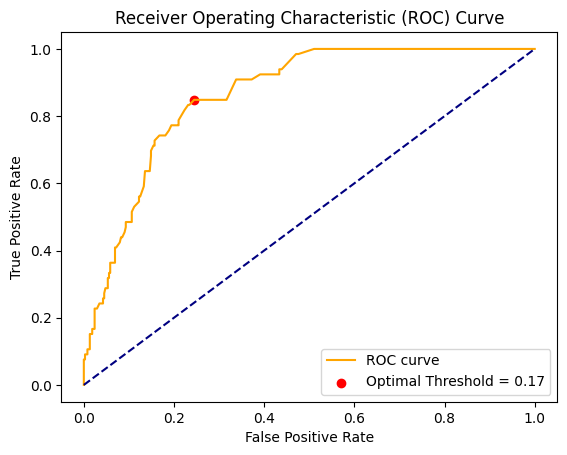

ROC 커브로부터 구한 AUC : 0.8636363636363636
              precision    recall  f1-score   support

          No       0.88      0.97      0.92       376
         Yes       0.58      0.23      0.33        66

    accuracy                           0.86       442
   macro avg       0.73      0.60      0.62       442
weighted avg       0.83      0.86      0.83       442



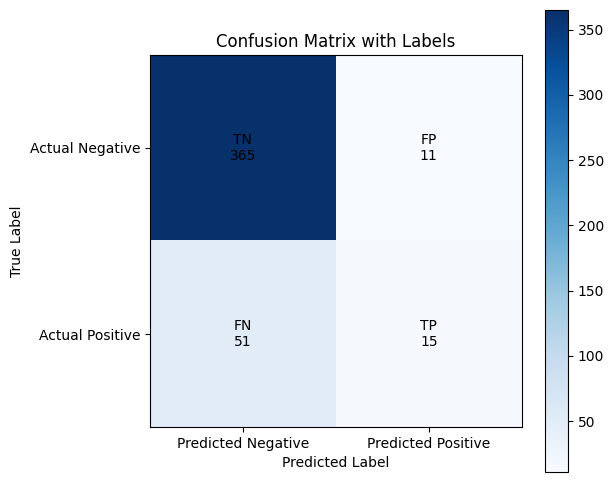

Composite Score :  0.6478350294207071
f1 Score :  0.3260869565217391
Accuracy :  0.8597285067873304
AUC :  0.8636363636363636


In [179]:
test_process(X_test, y_test, model)

# RandomForest / top 5, 10, 15 features / Default (1, 2, 3)


when using top 5 features


/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


              precision    recall  f1-score   support

          No       0.89      0.94      0.91       297
         Yes       0.56      0.40      0.47        57

    accuracy                           0.85       354
   macro avg       0.73      0.67      0.69       354
weighted avg       0.84      0.85      0.84       354



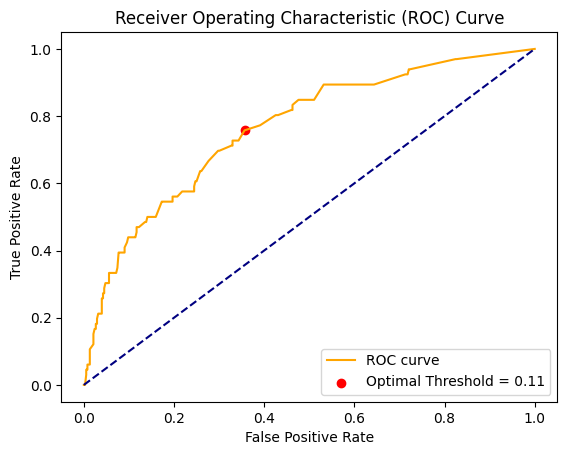

ROC 커브로부터 구한 AUC : 0.7632978723404256
              precision    recall  f1-score   support

          No       0.88      0.96      0.92       376
         Yes       0.53      0.26      0.35        66

    accuracy                           0.86       442
   macro avg       0.71      0.61      0.63       442
weighted avg       0.83      0.86      0.83       442



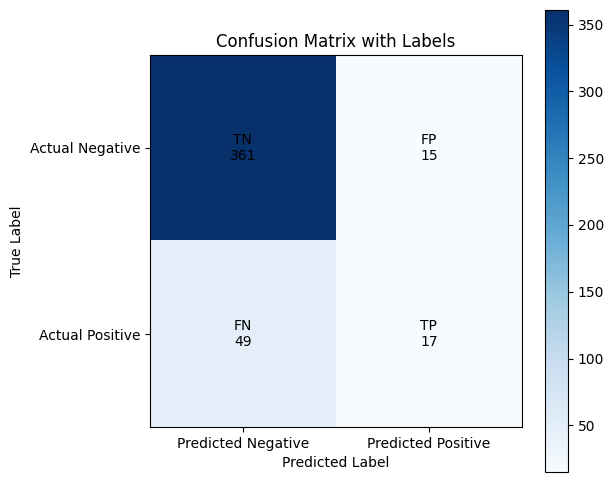

Composite Score :  0.6151353831221523
f1 Score :  0.3469387755102041
Accuracy :  0.8552036199095022
AUC :  0.7632978723404256
when using top 10 features


/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


              precision    recall  f1-score   support

          No       0.88      0.96      0.92       297
         Yes       0.61      0.30      0.40        57

    accuracy                           0.86       354
   macro avg       0.74      0.63      0.66       354
weighted avg       0.83      0.86      0.83       354



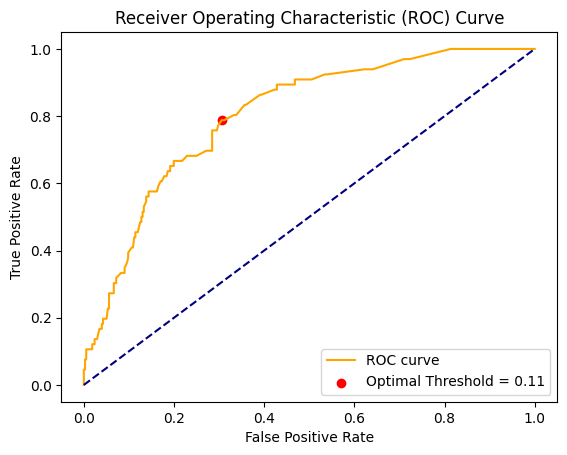

ROC 커브로부터 구한 AUC : 0.8031713410702772
              precision    recall  f1-score   support

          No       0.87      0.96      0.91       376
         Yes       0.43      0.18      0.26        66

    accuracy                           0.84       442
   macro avg       0.65      0.57      0.58       442
weighted avg       0.80      0.84      0.81       442



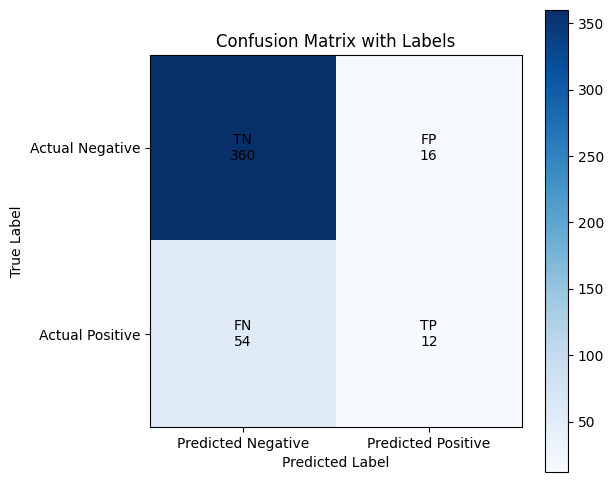

Composite Score :  0.5917219878577826
f1 Score :  0.2553191489361702
Accuracy :  0.8416289592760181
AUC :  0.8031713410702772
when using top 15 features


/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


              precision    recall  f1-score   support

          No       0.88      0.98      0.93       297
         Yes       0.78      0.32      0.45        57

    accuracy                           0.88       354
   macro avg       0.83      0.65      0.69       354
weighted avg       0.87      0.88      0.85       354



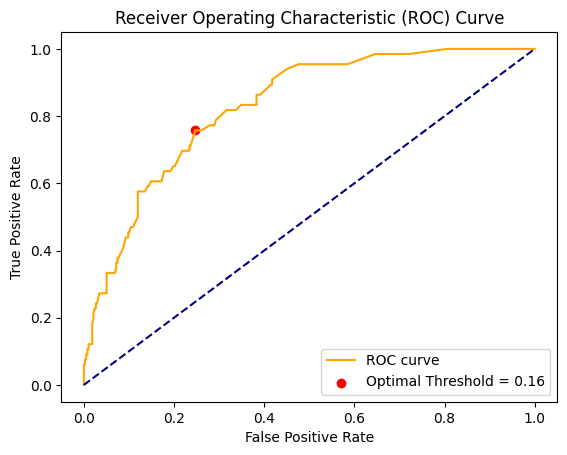

ROC 커브로부터 구한 AUC : 0.8288402643455836
              precision    recall  f1-score   support

          No       0.88      0.98      0.92       376
         Yes       0.64      0.21      0.32        66

    accuracy                           0.86       442
   macro avg       0.76      0.60      0.62       442
weighted avg       0.84      0.86      0.83       442



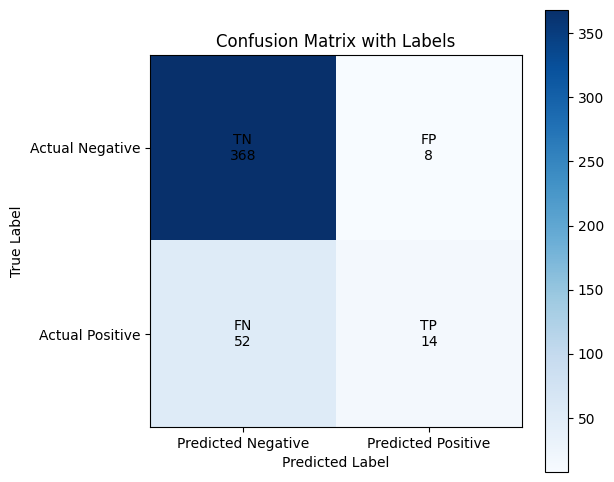

Composite Score :  0.6316595117439925
f1 Score :  0.3181818181818182
Accuracy :  0.8642533936651584
AUC :  0.8288402643455836


In [ ]:
# 상관계수 상위 5, 10, 15
num = [5, 10, 15]
target_column = ['Response']

for n in num:

    print('='*80)
    print(f'when using top {n} features')
    print('='*80)

    # 데이터 로드
    train = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/train_ver_1.csv')
    test = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/test_ver_1.csv')

    train = corr_selection(train, select_num=n)
    test = test[train.columns]

    X = train.drop(target_column, axis=1)
    y = train[target_column]

    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                            test_size=0.2,
                                                            random_state=42)

    X_test = test.drop(target_column, axis=1)
    y_test = test[target_column]

    pipe = make_pipeline(MinMaxScaler(),
                        RandomForestClassifier(
                            random_state=42
                        ))
    pipe.fit(X_train, y_train)

    # validation set test
    expected = y_val
    predicted = pipe.predict(X_val)
    predicted = predicted.flatten()
    predicted = np.where(predicted > 0.5, 1, 0)

    # f1 score, acc, ...
    classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
    print('='*80)
    print(classificationReport)
    print('='*80)

    test_process(X_test, y_test, pipe)

# RandomForest / All features / GridSearch / encoding


In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# 모델 설정
rf = RandomForestClassifier(random_state=42)

In [ ]:
# GridSearch
params = {
    'n_estimators' : [100, 200, 300],
    'max_depth' : [None, 10, 20, 30],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'max_features' : ['auto', 'sqrt'],
    'bootstrap' : [True, False],
    'class_weight' : [None, 'balanced']
}

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

grid_search = GridSearchCV(rf, param_grid=params,
                           scoring=scoring, refit='f1',
                           cv=5, verbose=2, n_jobs=-1,
                           return_train_score=True)

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', grid_search)
])

model.fit(X_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['Income', 'Kidhome',
                                                   'Teenhome', 'Dt_Customer',
                                                   'Recency', 'MntWines',
                                                   'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurch...
                              estimator=RandomForestClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'bootstrap': [True, False],
                                          'class_weight': [None, 'balanced'],
                                          'max_depth': [None, 10, 20, 30],
                                          'max_features': ['auto', 'sqrt'],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [100, 200, 300]},
                              refit='f1', return_train_score=True,
                              scoring={'accuracy': 'accuracy', 'f1': 'f1',
                                       'roc_auc': 'roc_auc'},
                              verbose=2))])

In [ ]:
# 결과 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (F1): {:.2f}".format(grid_search.best_score_))

#for scorer in scoring:
    # 각 스코어 매개변수에 따라 테스트 세트 점수 계산
    #print(f"{scorer}: {grid_search.scorer_[scorer](grid_search.best_estimator_, X_test, y_test)}")

Best parameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score (F1): 0.52


In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.93      0.92      0.93       297
         Yes       0.61      0.63      0.62        57

    accuracy                           0.88       354
   macro avg       0.77      0.78      0.77       354
weighted avg       0.88      0.88      0.88       354



              precision    recall  f1-score   support

          No       0.91      0.91      0.91       376
         Yes       0.48      0.45      0.47        66

    accuracy                           0.85       442
   macro avg       0.69      0.68      0.69       442
weighted avg       0.84      0.85      0.84       442



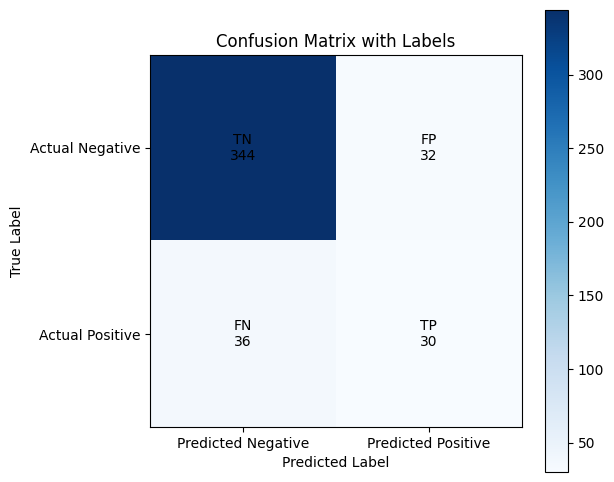

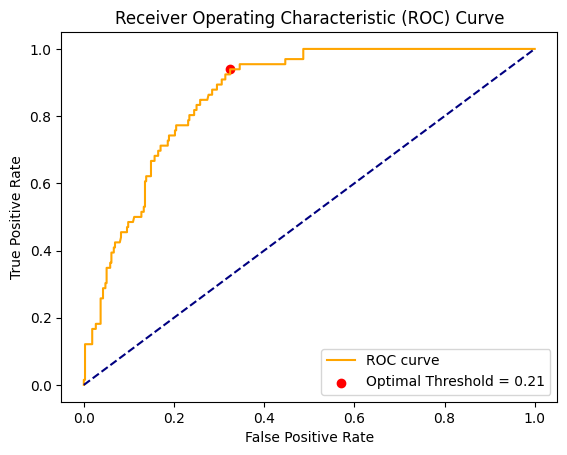

ROC 커브로부터 구한 AUC : 0.8645833333333333


In [ ]:
test_process(X_test, y_test, model)

# RandomForest / All features / 'bootstrap': False, 'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200 / encoding


In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(bootstrap=False,
                                          class_weight='balanced',
                                          max_features='auto',
                                          min_samples_leaf=4,
                                          min_samples_split=10,
                                          n_estimators=200,
                                          random_state=42))
])

model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['Income', 'Kidhome',
                                                   'Teenhome', 'Dt_Customer',
                                                   'Recency', 'MntWines',
                                                   'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'Complain', 'Age'])])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced',
                                        max_features='auto', min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=200,
                                        random_state=42))])

In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.93      0.92      0.93       297
         Yes       0.61      0.63      0.62        57

    accuracy                           0.88       354
   macro avg       0.77      0.78      0.77       354
weighted avg       0.88      0.88      0.88       354



              precision    recall  f1-score   support

          No       0.91      0.91      0.91       376
         Yes       0.48      0.45      0.47        66

    accuracy                           0.85       442
   macro avg       0.69      0.68      0.69       442
weighted avg       0.84      0.85      0.84       442



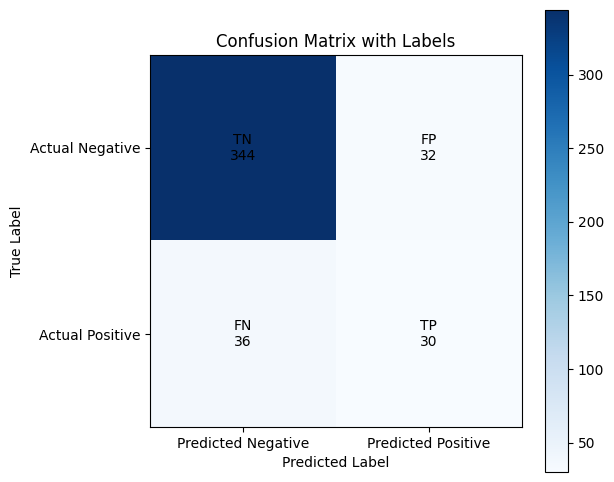

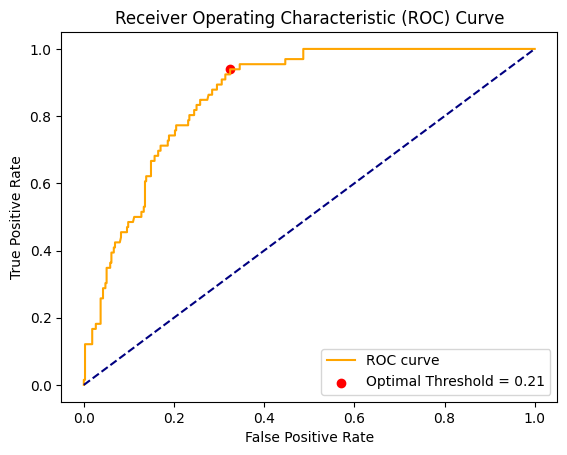

ROC 커브로부터 구한 AUC : 0.8645833333333333


In [ ]:
test_process(X_test, y_test, model)

# RandomForest / All features / GridSearch - class weight / encoding


In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# 모델 설정
rf = RandomForestClassifier(bootstrap=False,
                            class_weight='balanced',
                            max_features='auto',
                            min_samples_leaf=4,
                            min_samples_split=10,
                            n_estimators=200,
                            random_state=42)

In [ ]:
# GridSearch
params = {
    'class_weight' : ['balanced', {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:30}, {0:1, 1:50}]
}

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

grid_search = GridSearchCV(rf, param_grid=params,
                           scoring=scoring, refit='f1',
                           cv=5, verbose=2, n_jobs=-1,
                           return_train_score=True)

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', grid_search)
])

model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['Income', 'Kidhome',
                                                   'Teenhome', 'Dt_Customer',
                                                   'Recency', 'MntWines',
                                                   'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurch...
                              estimator=RandomForestClassifier(bootstrap=False,
                                                               class_weight='balanced',
                                                               max_features='auto',
                                                               min_samples_leaf=4,
                                                               min_samples_split=10,
                                                               n_estimators=200,
                                                               random_state=42),
                              n_jobs=-1,
                              param_grid={'class_weight': ['balanced',
                                                           {0: 1, 1: 10},
                                                           {0: 1, 1: 20},
                                                           {0: 1, 1: 30},
                                                           {0: 1, 1: 50}]},
                              refit='f1', return_train_score=True,
                              scoring={'accuracy': 'accuracy', 'f1': 'f1',
                                       'roc_auc': 'roc_auc'},
                              verbose=2))])

In [ ]:
# 결과 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (F1): {:.2f}".format(grid_search.best_score_))

#for scorer in scoring:
    # 각 스코어 매개변수에 따라 테스트 세트 점수 계산
    #print(f"{scorer}: {grid_search.scorer_[scorer](grid_search.best_estimator_, X_test, y_test)}")

Best parameters: {'class_weight': {0: 1, 1: 30}}
Best cross-validation score (F1): 0.54


In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.94      0.88      0.91       297
         Yes       0.53      0.72      0.61        57

    accuracy                           0.85       354
   macro avg       0.74      0.80      0.76       354
weighted avg       0.88      0.85      0.86       354



              precision    recall  f1-score   support

          No       0.91      0.88      0.89       376
         Yes       0.42      0.52      0.46        66

    accuracy                           0.82       442
   macro avg       0.67      0.70      0.68       442
weighted avg       0.84      0.82      0.83       442



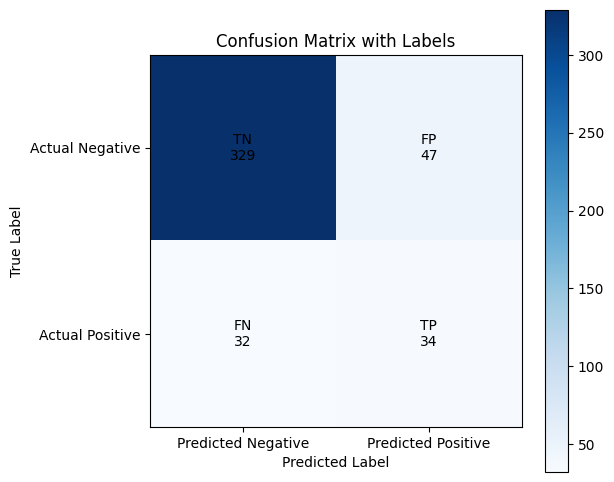

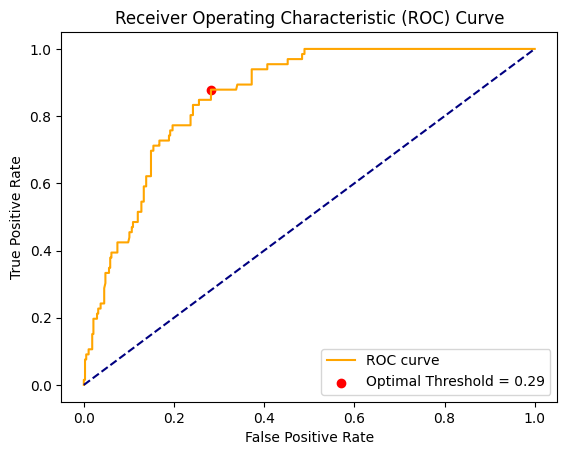

ROC 커브로부터 구한 AUC : 0.8605939716312057


In [ ]:
test_process(X_test, y_test, model)

# RandomForest / All features / GridSearch - min_samples_slit, min_samples_leaf / encoding


In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# 모델 설정
rf = RandomForestClassifier(bootstrap=False,
                            max_features='auto',
                            class_weight={0:1, 1:30},
                            n_estimators=200,
                            random_state=42)

In [ ]:
# GridSearch
params = {
    'min_samples_split' : [10, 15, 20],
    'min_samples_leaf' : [4, 6, 8, 10],
    'bootstrap' : [True, False]
}

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

grid_search = GridSearchCV(rf, param_grid=params,
                           scoring=scoring, refit='f1',
                           cv=5, verbose=2, n_jobs=-1,
                           return_train_score=True)

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', grid_search)
])

model.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['Income', 'Kidhome',
                                                   'Teenhome', 'Dt_Customer',
                                                   'Recency', 'MntWines',
                                                   'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurch...
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(bootstrap=False,
                                                               class_weight={0: 1,
                                                                             1: 30},
                                                               max_features='auto',
                                                               n_estimators=200,
                                                               random_state=42),
                              n_jobs=-1,
                              param_grid={'bootstrap': [True, False],
                                          'min_samples_leaf': [4, 6, 8, 10],
                                          'min_samples_split': [10, 15, 20]},
                              refit='f1', return_train_score=True,
                              scoring={'accuracy': 'accuracy', 'f1': 'f1',
                                       'roc_auc': 'roc_auc'},
                              verbose=2))])

In [ ]:
# 결과 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (F1): {:.2f}".format(grid_search.best_score_))

#for scorer in scoring:
    # 각 스코어 매개변수에 따라 테스트 세트 점수 계산
    #print(f"{scorer}: {grid_search.scorer_[scorer](grid_search.best_estimator_, X_test, y_test)}")

Best parameters: {'bootstrap': True, 'min_samples_leaf': 6, 'min_samples_split': 15}
Best cross-validation score (F1): 0.54


In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.96      0.82      0.88       297
         Yes       0.46      0.81      0.59        57

    accuracy                           0.82       354
   macro avg       0.71      0.81      0.73       354
weighted avg       0.88      0.82      0.83       354



              precision    recall  f1-score   support

          No       0.94      0.83      0.88       376
         Yes       0.42      0.68      0.52        66

    accuracy                           0.81       442
   macro avg       0.68      0.76      0.70       442
weighted avg       0.86      0.81      0.83       442



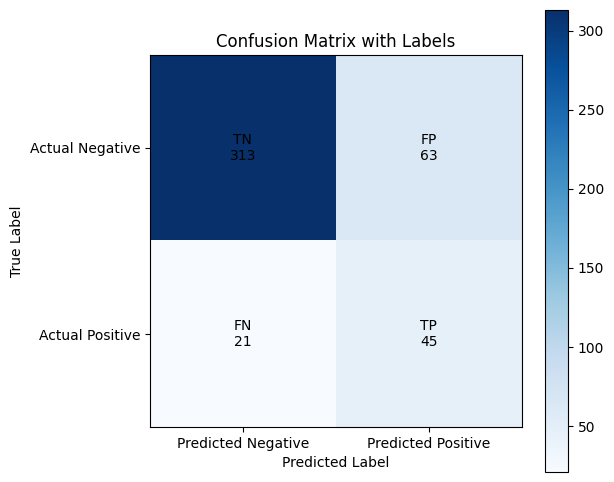

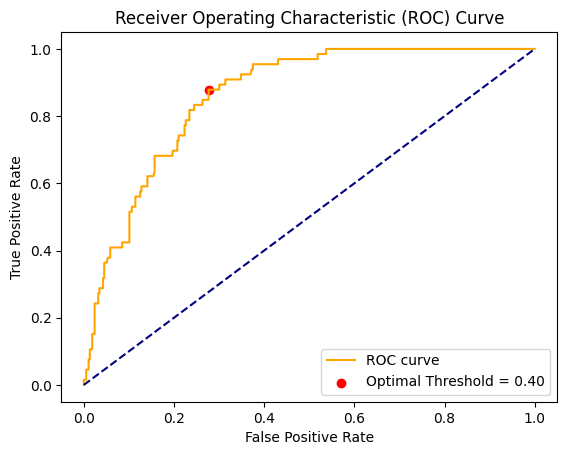

ROC 커브로부터 구한 AUC : 0.8613193101225017


In [ ]:
test_process(X_test, y_test, model)

# RandomForest / All features / 'bootstrap': True, 'class_weight': '0:1, 1:30', 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 200 / encoding (4)


In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(bootstrap=True,
                                          max_features='auto',
                                          min_samples_leaf=6,
                                          min_samples_split=15,
                                          class_weight={0:1, 1:30},
                                          n_estimators=200,
                                          random_state=42))
])

model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['Age', 'Complain',
                                                   'Dt_Customer', 'Income',
                                                   'Kidhome', 'MntFishProducts',
                                                   'MntFruits', 'MntGoldProds',
                                                   'MntMeatProducts',
                                                   'MntSweetProducts',
                                                   'MntWines',
                                                   'NumCatalogPurchases',
                                                   'NumDealsPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebPurchases',
                                                   'NumWebVisitsMonth',
                                                   'Recency', 'Teenhome'])])),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 30},
                                        max_features='auto', min_samples_leaf=6,
                                        min_samples_split=15, n_estimators=200,
                                        random_state=42))])

In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.96      0.82      0.88       297
         Yes       0.46      0.81      0.59        57

    accuracy                           0.82       354
   macro avg       0.71      0.81      0.73       354
weighted avg       0.88      0.82      0.83       354



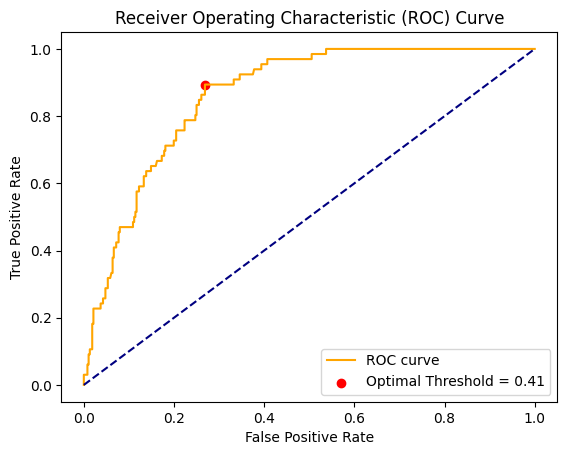

ROC 커브로부터 구한 AUC : 0.8620446486137976
              precision    recall  f1-score   support

          No       0.93      0.83      0.88       376
         Yes       0.40      0.67      0.50        66

    accuracy                           0.80       442
   macro avg       0.67      0.75      0.69       442
weighted avg       0.85      0.80      0.82       442



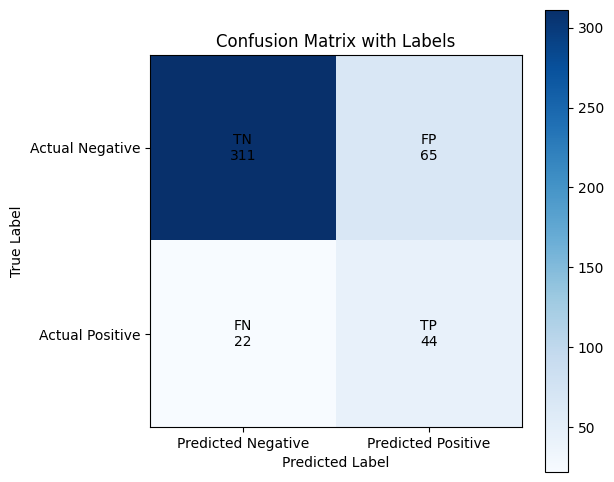

Composite Score :  0.7065942007512722
f1 Score :  0.5028571428571428
Accuracy :  0.8031674208144797
AUC :  0.8620446486137976


In [ ]:
test_process(X_test, y_test, model)

# RandomForest / All features / GridSearch another try / encoding


In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# 모델 설정
rf = RandomForestClassifier(bootstrap=False,
                            max_features='auto',
                            min_samples_leaf=4,
                            min_samples_split=10,
                            random_state=42)

In [ ]:
# GridSearch
params = {
    'n_estimators' : [300, 400],
    'bootstrap' : [True, False],
    'class_weight' : [{0:1, 1:30}, {0:1, 1:40}]
}

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

grid_search = GridSearchCV(rf, param_grid=params,
                           scoring=scoring, refit='f1',
                           cv=5, verbose=2, n_jobs=-1,
                           return_train_score=True)

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', grid_search)
])

model.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['Income', 'Kidhome',
                                                   'Teenhome', 'Dt_Customer',
                                                   'Recency', 'MntWines',
                                                   'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurch...
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(bootstrap=False,
                                                               max_features='auto',
                                                               min_samples_leaf=4,
                                                               min_samples_split=10,
                                                               random_state=42),
                              n_jobs=-1,
                              param_grid={'bootstrap': [True, False],
                                          'class_weight': [{0: 1, 1: 30},
                                                           {0: 1, 1: 40}],
                                          'n_estimators': [300, 400]},
                              refit='f1', return_train_score=True,
                              scoring={'accuracy': 'accuracy', 'f1': 'f1',
                                       'roc_auc': 'roc_auc'},
                              verbose=2))])

In [ ]:
# 결과 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (F1): {:.2f}".format(grid_search.best_score_))

#for scorer in scoring:
    # 각 스코어 매개변수에 따라 테스트 세트 점수 계산
    #print(f"{scorer}: {grid_search.scorer_[scorer](grid_search.best_estimator_, X_test, y_test)}")

Best parameters: {'bootstrap': False, 'class_weight': {0: 1, 1: 30}, 'n_estimators': 400}
Best cross-validation score (F1): 0.55


In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.94      0.89      0.91       297
         Yes       0.53      0.68      0.60        57

    accuracy                           0.85       354
   macro avg       0.74      0.78      0.76       354
weighted avg       0.87      0.85      0.86       354



              precision    recall  f1-score   support

          No       0.91      0.88      0.89       376
         Yes       0.42      0.52      0.46        66

    accuracy                           0.82       442
   macro avg       0.67      0.70      0.68       442
weighted avg       0.84      0.82      0.83       442



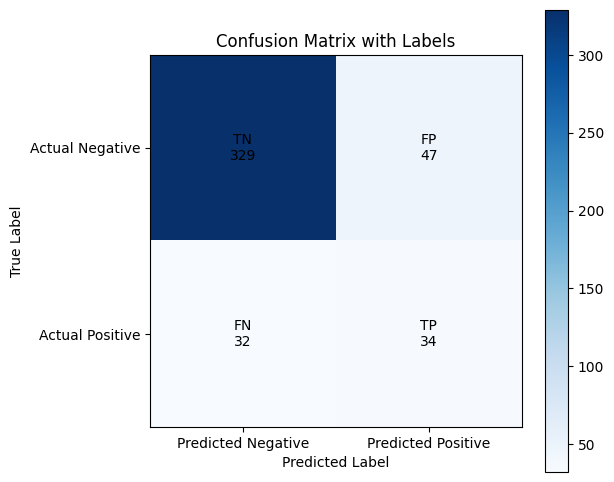

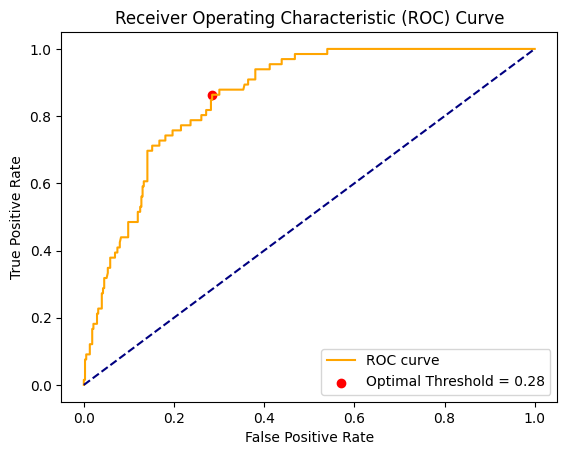

ROC 커브로부터 구한 AUC : 0.8589015151515152


In [ ]:
test_process(X_test, y_test, model)

# RandomForest / All features / AutoML SMOTE / encoding (5)



In [ ]:
# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/train_SMOTE.csv')
val = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/val_SMOTE.csv')
test = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/test_SMOTE.csv')

train = train.sort_index(axis=1)
val = val.sort_index(axis=1)
test = test.sort_index(axis=1)

target_column = ['Response']

X_train = train.drop(target_column, axis=1)
y_train = train[target_column]

X_val = val.drop(target_column, axis=1)
y_val = val[target_column]

X_test = test.drop(target_column, axis=1)
y_test = test[target_column]

In [ ]:
# 파이프라인 설정
pipe = make_pipeline(MinMaxScaler(),
                     RandomForestClassifier(
                        random_state=42
                     ))
pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [ ]:
# validation set test
expected = y_val
predicted = pipe.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.90      0.96      0.93       297
         Yes       0.69      0.47      0.56        57

    accuracy                           0.88       354
   macro avg       0.80      0.72      0.75       354
weighted avg       0.87      0.88      0.87       354



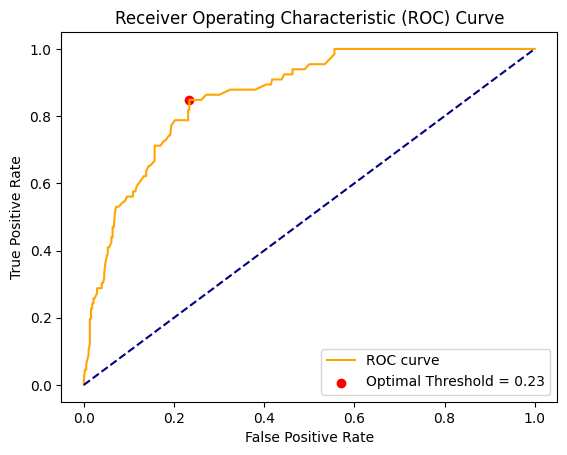

ROC 커브로부터 구한 AUC : 0.8636968085106383
              precision    recall  f1-score   support

          No       0.90      0.95      0.92       376
         Yes       0.57      0.36      0.44        66

    accuracy                           0.86       442
   macro avg       0.73      0.66      0.68       442
weighted avg       0.85      0.86      0.85       442



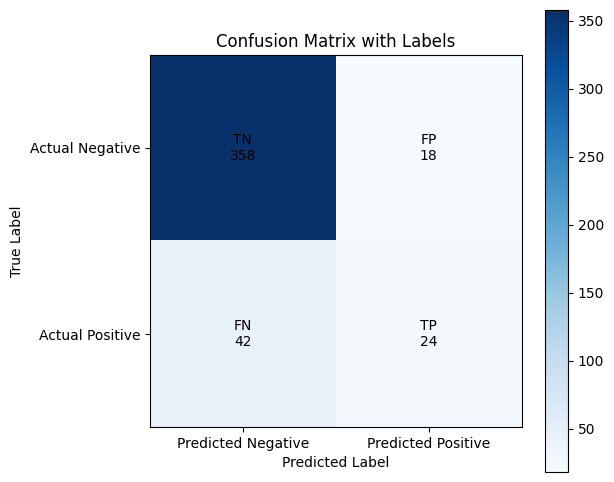

Composite Score :  0.6961071799150649
f1 Score :  0.4444444444444444
Accuracy :  0.8642533936651584
AUC :  0.8636968085106383


In [ ]:
test_process(X_test, y_test, pipe)

# RandomForest / All features / AutoML SMOTE / GridSearch / encoding


In [ ]:
# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/train_SMOTE.csv')
val = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/val_SMOTE.csv')
test = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/test_SMOTE.csv')

train = train.sort_index(axis=1)
val = val.sort_index(axis=1)
test = test.sort_index(axis=1)

target_column = ['Response']

X_train = train.drop(target_column, axis=1)
y_train = train[target_column]

X_val = val.drop(target_column, axis=1)
y_val = val[target_column]

X_test = test.drop(target_column, axis=1)
y_test = test[target_column]

categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# 모델 설정
rf = RandomForestClassifier(random_state=42)

In [ ]:
# GridSearch
params = {
    'n_estimators' : [200, 300, 400],
    'max_depth' : [None, 10, 20],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [2, 4, 6],
    'max_features' : ['auto'],
    'bootstrap' : [True, False],
    'class_weight' : [None, 'balanced', {0:1, 1:10}]
}

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

grid_search = GridSearchCV(rf, param_grid=params,
                           scoring=scoring, refit='f1',
                           cv=5, verbose=2, n_jobs=-1,
                           return_train_score=True)

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', grid_search)
])

model.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['Age', 'Complain',
                                                   'Dt_Customer',
                                                   'Education_2n Cycle',
                                                   'Education_Basic',
                                                   'Education_Graduation',
                                                   'Education_Master',
                                                   'Education_PhD', 'Income',
                                                   'Kidhome',
                                                   'Marital_Status_Divorced',
                                                   'Marital_Status_Married',
                                                   'Marital_Status_Single',
                                                   'Marital_Status_Together',
                                                   'Marital_Stat...
                              estimator=RandomForestClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'bootstrap': [True, False],
                                          'class_weight': [None, 'balanced',
                                                           {0: 1, 1: 10}],
                                          'max_depth': [None, 10, 20],
                                          'max_features': ['auto'],
                                          'min_samples_leaf': [2, 4, 6],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [200, 300, 400]},
                              refit='f1', return_train_score=True,
                              scoring={'accuracy': 'accuracy', 'f1': 'f1',
                                       'roc_auc': 'roc_auc'},
                              verbose=2))])

In [ ]:
# 결과 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (F1): {:.2f}".format(grid_search.best_score_))

#for scorer in scoring:
    # 각 스코어 매개변수에 따라 테스트 세트 점수 계산
    #print(f"{scorer}: {grid_search.scorer_[scorer](grid_search.best_estimator_, X_test, y_test)}")

Best parameters: {'bootstrap': False, 'class_weight': None, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score (F1): 0.90


In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.91      0.96      0.93       297
         Yes       0.72      0.49      0.58        57

    accuracy                           0.89       354
   macro avg       0.81      0.73      0.76       354
weighted avg       0.88      0.89      0.88       354



              precision    recall  f1-score   support

          No       0.89      0.95      0.92       376
         Yes       0.56      0.33      0.42        66

    accuracy                           0.86       442
   macro avg       0.73      0.64      0.67       442
weighted avg       0.84      0.86      0.85       442



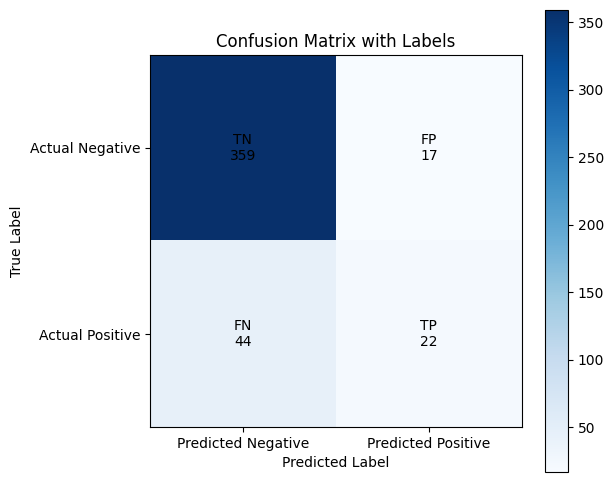

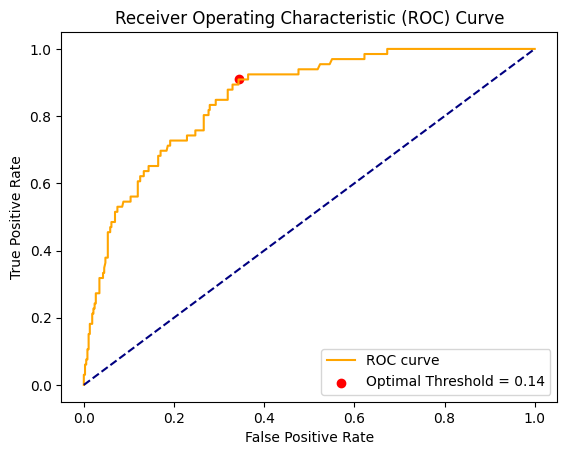

ROC 커브로부터 구한 AUC : 0.8549927466150871


In [ ]:
test_process(X_test, y_test, model)

# RandomForest / All features / AutoML SMOTE / 'bootstrap': False, 'class_weight': None, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200 / encoding (6)


In [ ]:
# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/train_SMOTE.csv')
val = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/val_SMOTE.csv')
test = pd.read_csv('/content/drive/MyDrive/데브코스/project_3/data/test_SMOTE.csv')

train = train.sort_index(axis=1)
val = val.sort_index(axis=1)
test = test.sort_index(axis=1)

target_column = ['Response']

X_train = train.drop(target_column, axis=1)
y_train = train[target_column]

X_val = val.drop(target_column, axis=1)
y_val = val[target_column]

X_test = test.drop(target_column, axis=1)
y_test = test[target_column]

categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# 파이프라인 설정
pipe = make_pipeline(MinMaxScaler(),
                     RandomForestClassifier(
                        bootstrap=False,
                        class_weight=None,
                        max_depth=None,
                        max_features='auto',
                        min_samples_leaf=2,
                        min_samples_split=2,
                        n_estimators=200,
                        random_state=42
                     ))
pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_features='auto',
                                        min_samples_leaf=2, n_estimators=200,
                                        random_state=42))])

In [ ]:
# validation set test
expected = y_val
predicted = pipe.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.91      0.96      0.93       297
         Yes       0.72      0.49      0.58        57

    accuracy                           0.89       354
   macro avg       0.81      0.73      0.76       354
weighted avg       0.88      0.89      0.88       354



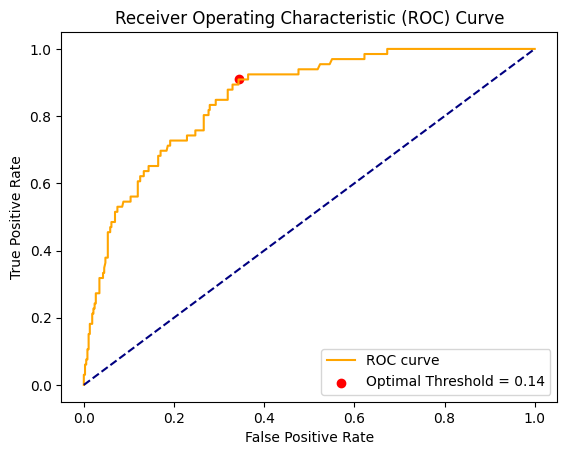

ROC 커브로부터 구한 AUC : 0.8549927466150871
              precision    recall  f1-score   support

          No       0.89      0.95      0.92       376
         Yes       0.56      0.33      0.42        66

    accuracy                           0.86       442
   macro avg       0.73      0.64      0.67       442
weighted avg       0.84      0.86      0.85       442



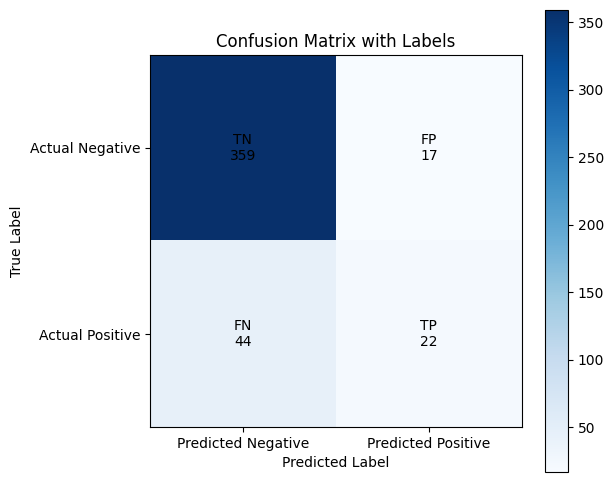

Composite Score :  0.6820143363103314
f1 Score :  0.41904761904761906
Accuracy :  0.8619909502262444
AUC :  0.8549927466150871


In [ ]:
test_process(X_test, y_test, pipe)

# RandomForest / All features / SMOTE / encoding (7)



In [143]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [144]:
# 훈련 데이터에 SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 재샘플링 후 클래스 분포 확인
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: Response
0           1204
1            208
Name: count, dtype: int64
After SMOTE: Response
0           1204
1           1204
Name: count, dtype: int64


In [145]:
# 파이프라인 설정
pipe = make_pipeline(MinMaxScaler(),
                     RandomForestClassifier(
                        random_state=42
                     ))
pipe.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [146]:
# validation set test
expected = y_val
predicted = pipe.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.93      0.92      0.92       297
         Yes       0.60      0.65      0.62        57

    accuracy                           0.87       354
   macro avg       0.76      0.78      0.77       354
weighted avg       0.88      0.87      0.88       354



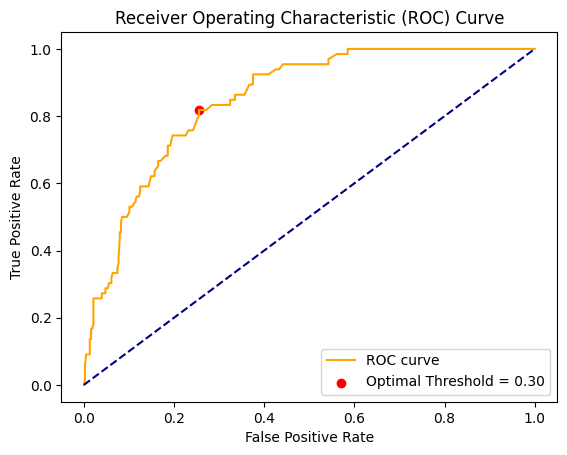

ROC 커브로부터 구한 AUC : 0.849814635718891
              precision    recall  f1-score   support

          No       0.91      0.90      0.91       376
         Yes       0.48      0.50      0.49        66

    accuracy                           0.84       442
   macro avg       0.69      0.70      0.70       442
weighted avg       0.85      0.84      0.85       442



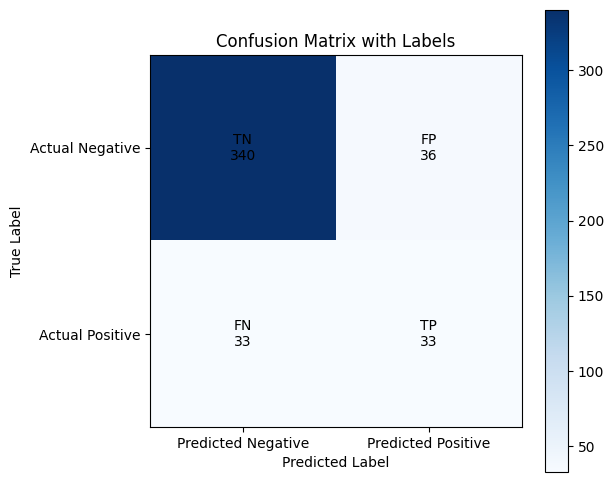

Composite Score :  0.7042596903860985
f1 Score :  0.4888888888888889
Accuracy :  0.8438914027149321
AUC :  0.849814635718891


In [151]:
test_process(X_test, y_test, pipe)

# RandomForest / All features / SMOTE / GridSearch / encoding


In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# 훈련 데이터에 SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 재샘플링 후 클래스 분포 확인
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: Response
0           1204
1            208
Name: count, dtype: int64
After SMOTE: Response
0           1204
1           1204
Name: count, dtype: int64


In [ ]:
# 모델 설정
rf = RandomForestClassifier(random_state=42)

In [ ]:
# GridSearch
params = {
    'n_estimators' : [200, 300, 400],
    'max_depth' : [None, 10, 20],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [2, 4, 6],
    'max_features' : ['auto'],
    'bootstrap' : [True, False],
    'class_weight' : [None, 'balanced', {0:1, 1:10}]
}

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

grid_search = GridSearchCV(rf, param_grid=params,
                           scoring=scoring, refit='f1',
                           cv=5, verbose=2, n_jobs=-1,
                           return_train_score=True)

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', grid_search)
])

model.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['Age', 'Complain',
                                                   'Dt_Customer',
                                                   'Education_Basic',
                                                   'Education_Graduation',
                                                   'Education_Master',
                                                   'Education_PhD', 'Income',
                                                   'Kidhome',
                                                   'Marital_Status_Married',
                                                   'Marital_Status_Single',
                                                   'Marital_Status_Together',
                                                   'Marital_Status_Widow',
                                                   'MntFishProducts',
                                                   'MntFruits', 'MntGo...
                              estimator=RandomForestClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'bootstrap': [True, False],
                                          'class_weight': [None, 'balanced',
                                                           {0: 1, 1: 10}],
                                          'max_depth': [None, 10, 20],
                                          'max_features': ['auto'],
                                          'min_samples_leaf': [2, 4, 6],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [200, 300, 400]},
                              refit='f1', return_train_score=True,
                              scoring={'accuracy': 'accuracy', 'f1': 'f1',
                                       'roc_auc': 'roc_auc'},
                              verbose=2))])

In [ ]:
# 결과 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (F1): {:.2f}".format(grid_search.best_score_))

#for scorer in scoring:
    # 각 스코어 매개변수에 따라 테스트 세트 점수 계산
    #print(f"{scorer}: {grid_search.scorer_[scorer](grid_search.best_estimator_, X_test, y_test)}")

Best parameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
Best cross-validation score (F1): 0.93


In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.93      0.93      0.93       297
         Yes       0.63      0.63      0.63        57

    accuracy                           0.88       354
   macro avg       0.78      0.78      0.78       354
weighted avg       0.88      0.88      0.88       354



              precision    recall  f1-score   support

          No       0.91      0.92      0.92       376
         Yes       0.52      0.48      0.50        66

    accuracy                           0.86       442
   macro avg       0.71      0.70      0.71       442
weighted avg       0.85      0.86      0.85       442



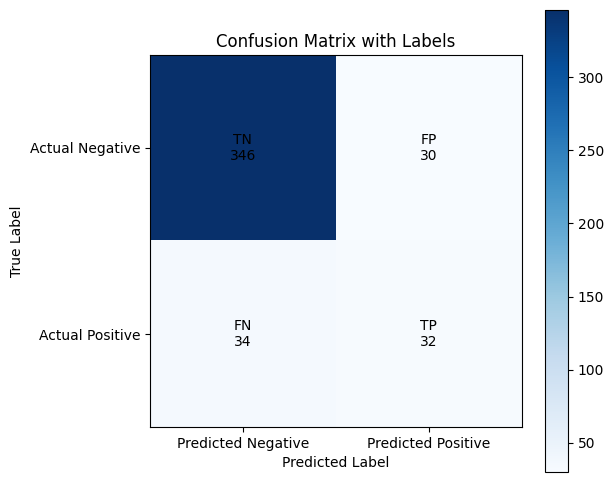

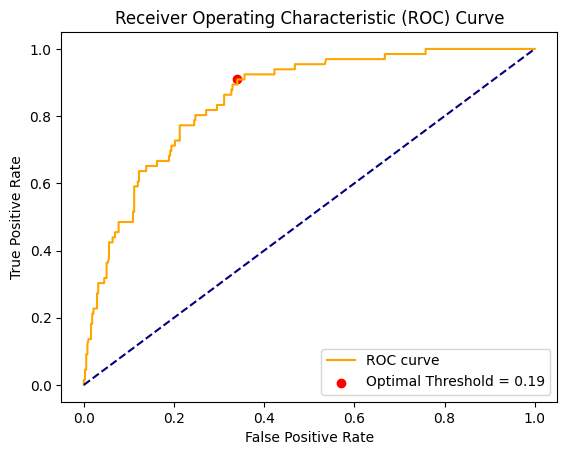

ROC 커브로부터 구한 AUC : 0.8522122823984526


In [ ]:
test_process(X_test_over, y_test_over, model)

# RandomForest / All features / SMOTE / GridSearch_2 / encoding


In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# 훈련 데이터에 SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 재샘플링 후 클래스 분포 확인
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: Response
0           1204
1            208
Name: count, dtype: int64
After SMOTE: Response
0           1204
1           1204
Name: count, dtype: int64


In [ ]:
# 모델 설정
rf = RandomForestClassifier(
    class_weight='balanced',
    max_features='auto',
    min_samples_leaf=2,
    min_samples_split=2,
    random_state=42
)

In [ ]:
# GridSearch
params = {
    'n_estimators' : [400, 500, 600],
    'max_depth' : [None, 10, 20, 30, 40],
    'bootstrap' : [True, False]
}

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

grid_search = GridSearchCV(rf, param_grid=params,
                           scoring=scoring, refit='f1',
                           cv=5, verbose=2, n_jobs=-1,
                           return_train_score=True)

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', grid_search)
])

model.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['Age', 'Complain',
                                                   'Dt_Customer',
                                                   'Education_Basic',
                                                   'Education_Graduation',
                                                   'Education_Master',
                                                   'Education_PhD', 'Income',
                                                   'Kidhome',
                                                   'Marital_Status_Married',
                                                   'Marital_Status_Single',
                                                   'Marital_Status_Together',
                                                   'Marital_Status_Widow',
                                                   'MntFishProducts',
                                                   'MntFruits', 'MntGo...
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(class_weight='balanced',
                                                               max_features='auto',
                                                               min_samples_leaf=2,
                                                               random_state=42),
                              n_jobs=-1,
                              param_grid={'bootstrap': [True, False],
                                          'max_depth': [None, 10, 20, 30, 40],
                                          'n_estimators': [400, 500, 600]},
                              refit='f1', return_train_score=True,
                              scoring={'accuracy': 'accuracy', 'f1': 'f1',
                                       'roc_auc': 'roc_auc'},
                              verbose=2))])

In [ ]:
# 결과 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (F1): {:.2f}".format(grid_search.best_score_))

#for scorer in scoring:
    # 각 스코어 매개변수에 따라 테스트 세트 점수 계산
    #print(f"{scorer}: {grid_search.scorer_[scorer](grid_search.best_estimator_, X_test, y_test)}")

Best parameters: {'bootstrap': False, 'max_depth': 20, 'n_estimators': 500}
Best cross-validation score (F1): 0.93


In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.93      0.93      0.93       297
         Yes       0.65      0.65      0.65        57

    accuracy                           0.89       354
   macro avg       0.79      0.79      0.79       354
weighted avg       0.89      0.89      0.89       354



              precision    recall  f1-score   support

          No       0.91      0.92      0.91       376
         Yes       0.50      0.47      0.48        66

    accuracy                           0.85       442
   macro avg       0.70      0.69      0.70       442
weighted avg       0.85      0.85      0.85       442



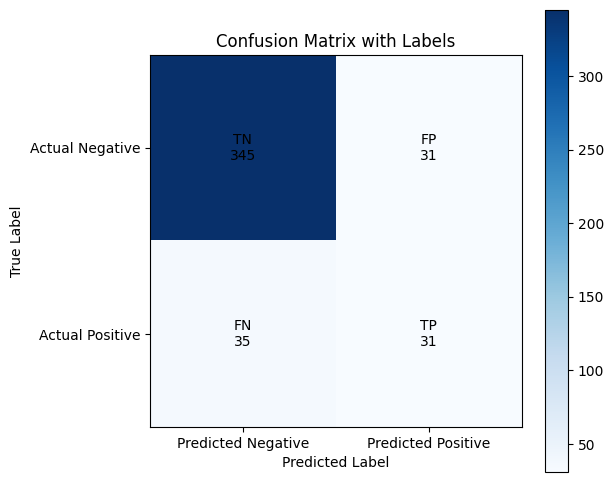

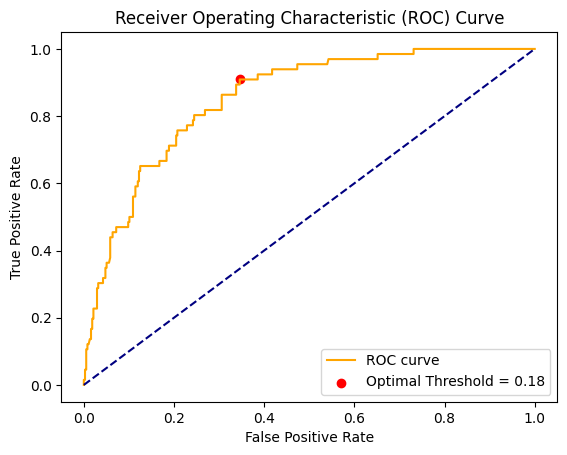

ROC 커브로부터 구한 AUC : 0.8524137653127014


In [ ]:
test_process(X_test_over, y_test_over, model)

# RandomForest / All features / SMOTE / 'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400 / encoding (8)



In [160]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [161]:
# 훈련 데이터에 SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 재샘플링 후 클래스 분포 확인
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: Response
0           1204
1            208
Name: count, dtype: int64
After SMOTE: Response
0           1204
1           1204
Name: count, dtype: int64


In [162]:
# 파이프라인 설정
pipe = make_pipeline(MinMaxScaler(),
                     RandomForestClassifier(
                        bootstrap=False,
                        class_weight='balanced',
                        max_depth=20,
                        max_features='auto',
                        min_samples_leaf=2,
                        min_samples_split=2,
                        n_estimators=400,
                        random_state=42
                     ))
pipe.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced', max_depth=20,
                                        max_features='auto', min_samples_leaf=2,
                                        n_estimators=400, random_state=42))])

In [163]:
# validation set test
expected = y_val
predicted = pipe.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.93      0.93      0.93       297
         Yes       0.63      0.63      0.63        57

    accuracy                           0.88       354
   macro avg       0.78      0.78      0.78       354
weighted avg       0.88      0.88      0.88       354



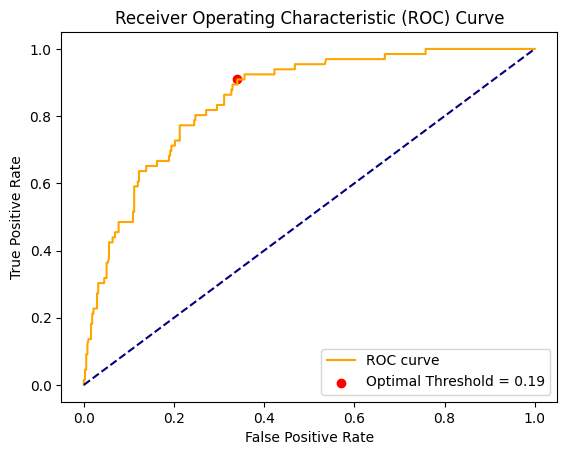

ROC 커브로부터 구한 AUC : 0.8522122823984526
              precision    recall  f1-score   support

          No       0.91      0.92      0.92       376
         Yes       0.52      0.48      0.50        66

    accuracy                           0.86       442
   macro avg       0.71      0.70      0.71       442
weighted avg       0.85      0.86      0.85       442



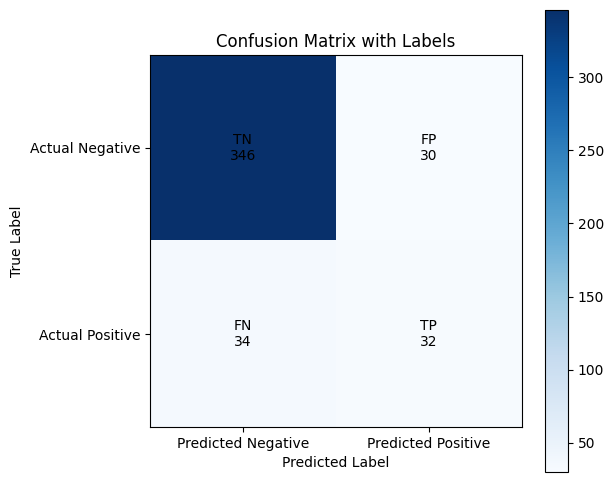

Composite Score :  0.7119256369412815
f1 Score :  0.5
Accuracy :  0.8552036199095022
AUC :  0.8522122823984526


In [164]:
test_process(X_test, y_test, pipe)

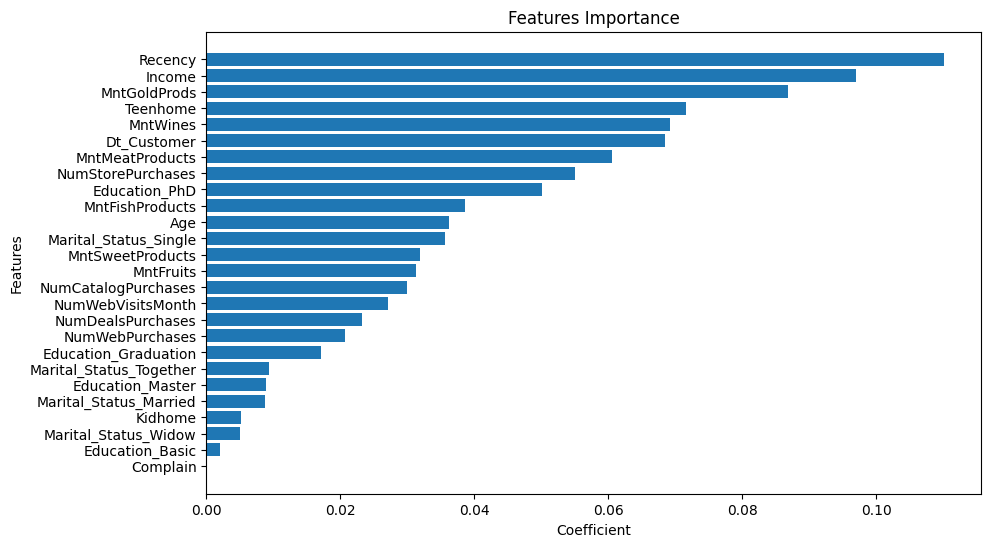

,feature,coefficient,abs_coefficient
24,Recency,0.110159,0.110159
7,Income,0.096973,0.096973
15,MntGoldProds,0.086846,0.086846
25,Teenhome,0.071555,0.071555
18,MntWines,0.069150,0.069150
2,Dt_Customer,0.068537,0.068537
16,MntMeatProducts,0.060581,0.060581
21,NumStorePurchases,0.054968,0.054968
6,Education_PhD,0.050059,0.050059
13,MntFishProducts,0.038682,0.038682


In [165]:
# feature importance
feature_importances = pipe.named_steps['randomforestclassifier'].feature_importances_

importance_df = importance_visualization(X_test, feature_importances)

importance_df

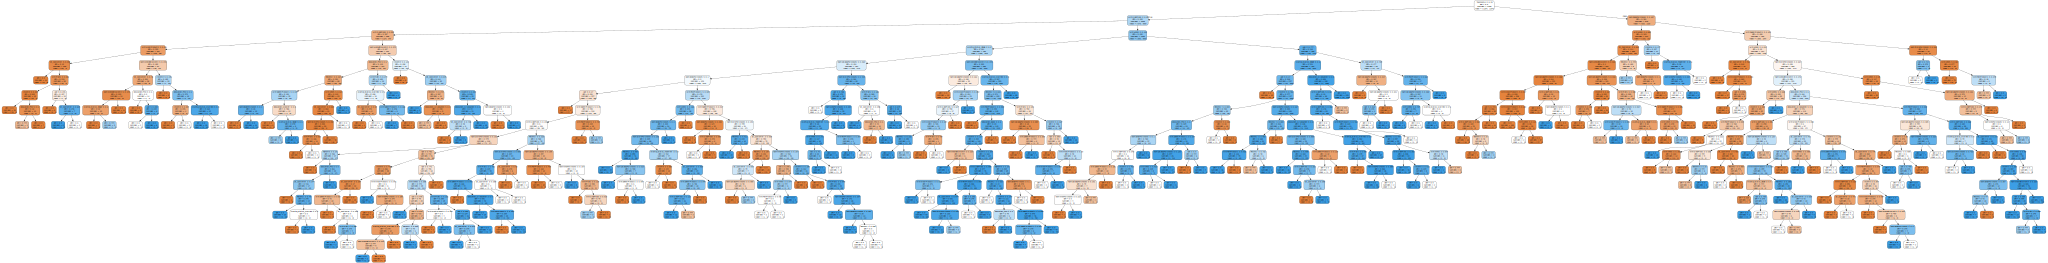

In [167]:
# 첫 번째 트리 추출 및 DOT 데이터 생성
first_tree = pipe.named_steps['randomforestclassifier'].estimators_[0]
dot_data = export_graphviz(first_tree, out_file=None,
                           feature_names=X_test.columns,
                           filled=True, rounded=True, special_characters=True)

# 그래프 생성
graph = graphviz.Source(dot_data)
graph.render("Random_Forest_Tree_First", format='png', cleanup=True)
graph

# RandomForest / All features / BorderlineSMOTE / encoding (9)



In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# 훈련 데이터에 SMOTE 적용
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 재샘플링 후 클래스 분포 확인
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: Response
0           1204
1            208
Name: count, dtype: int64
After SMOTE: Response
0           1204
1           1204
Name: count, dtype: int64


In [ ]:
# 파이프라인 설정
pipe = make_pipeline(MinMaxScaler(),
                     RandomForestClassifier(
                        random_state=42
                     ))
pipe.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [ ]:
# validation set test
expected = y_val
predicted = pipe.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.94      0.93      0.93       297
         Yes       0.64      0.68      0.66        57

    accuracy                           0.89       354
   macro avg       0.79      0.81      0.80       354
weighted avg       0.89      0.89      0.89       354



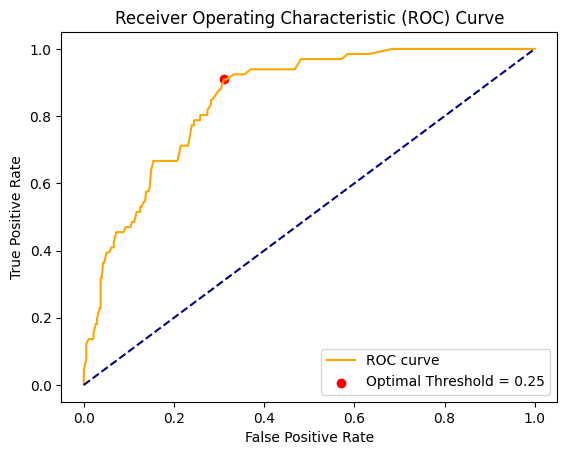

ROC 커브로부터 구한 AUC : 0.8526152482269503
              precision    recall  f1-score   support

          No       0.91      0.90      0.91       376
         Yes       0.46      0.47      0.47        66

    accuracy                           0.84       442
   macro avg       0.68      0.69      0.69       442
weighted avg       0.84      0.84      0.84       442



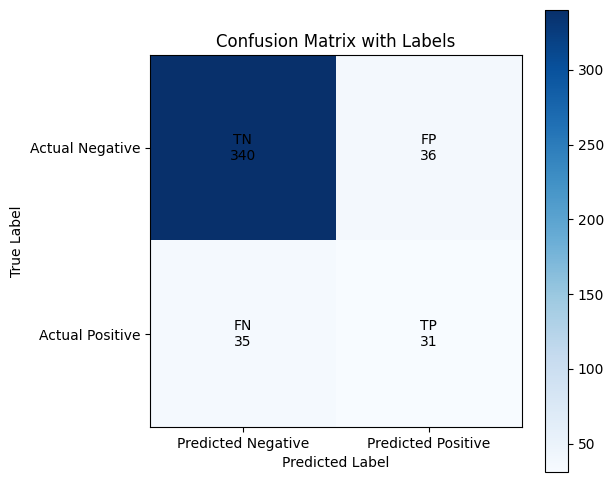

Composite Score :  0.6953855678717349
f1 Score :  0.4661654135338346
Accuracy :  0.8393665158371041
AUC :  0.8526152482269503


In [ ]:
test_process(X_test, y_test, pipe)

# RandomForest / All features / Default / Labelencoding



In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# LabelEncoder 객체 생성
encoder = LabelEncoder()

# 데이터에 fit_transform 메서드 적용
X_train['Education'] = encoder.fit_transform(X_train['Education'])
X_train['Marital_Status'] = encoder.fit_transform(X_train['Marital_Status'])

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['Age', 'Complain',
                                                   'Dt_Customer', 'Income',
                                                   'Kidhome', 'MntFishProducts',
                                                   'MntFruits', 'MntGoldProds',
                                                   'MntMeatProducts',
                                                   'MntSweetProducts',
                                                   'MntWines',
                                                   'NumCatalogPurchases',
                                                   'NumDealsPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebPurchases',
                                                   'NumWebVisitsMonth',
                                                   'Recency', 'Teenhome'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.89      0.99      0.93       297
         Yes       0.83      0.35      0.49        57

    accuracy                           0.88       354
   macro avg       0.86      0.67      0.71       354
weighted avg       0.88      0.88      0.86       354



              precision    recall  f1-score   support

          No       0.87      0.96      0.91       376
         Yes       0.42      0.17      0.24        66

    accuracy                           0.84       442
   macro avg       0.65      0.56      0.58       442
weighted avg       0.80      0.84      0.81       442



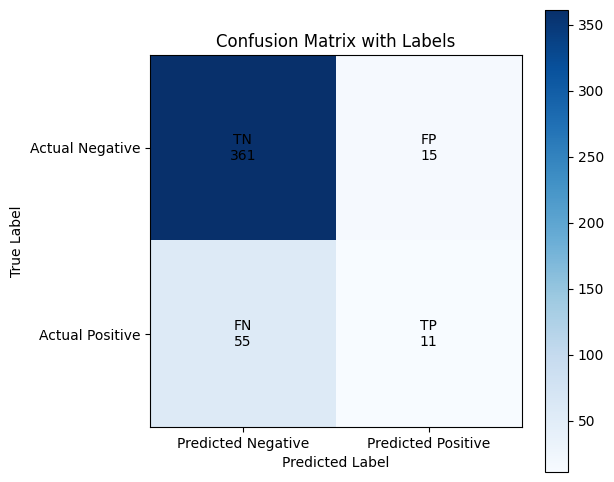

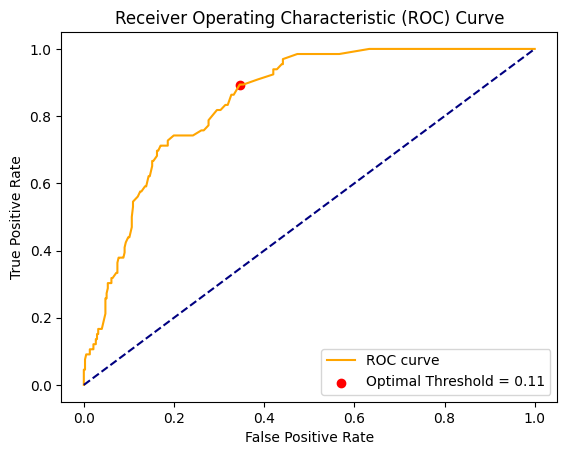

ROC 커브로부터 구한 AUC : 0.846611057382334
Composite Score :  0.6026223887211808


In [ ]:
test_process(X_test, y_test, model)

# RandomForest / All features / GridSearch / Labelencoding


In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# LabelEncoder 객체 생성
encoder = LabelEncoder()

# 데이터에 fit_transform 메서드 적용
X_train['Education'] = encoder.fit_transform(X_train['Education'])
X_train['Marital_Status'] = encoder.fit_transform(X_train['Marital_Status'])

In [ ]:
# 모델 설정
rf = RandomForestClassifier(bootstrap=False,
                            max_features='auto',
                            min_samples_leaf=4,
                            min_samples_split=10,
                            random_state=42)

In [ ]:
# GridSearch
params = {
    'n_estimators' : [300, 400, 500],
    'bootstrap' : [True, False],
    'class_weight' : [{0:1, 1:30}, {0:1, 1:40}, {0:1, 1:50}]
}

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

grid_search = GridSearchCV(rf, param_grid=params,
                           scoring=scoring, refit='f1',
                           cv=5, verbose=2, n_jobs=-1,
                           return_train_score=True)

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', grid_search)
])

model.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['Age', 'Complain',
                                                   'Dt_Customer', 'Income',
                                                   'Kidhome', 'MntFishProducts',
                                                   'MntFruits', 'MntGoldProds',
                                                   'MntMeatProducts',
                                                   'MntSweetProducts',
                                                   'MntWines',
                                                   'NumCatalogPurchases',
                                                   'NumDealsPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebPurchases',
                                                   'NumWebVisitsMonth',
                                                   'Recency', 'Teenho...
                              estimator=RandomForestClassifier(bootstrap=False,
                                                               max_features='auto',
                                                               min_samples_leaf=4,
                                                               min_samples_split=10,
                                                               random_state=42),
                              n_jobs=-1,
                              param_grid={'bootstrap': [True, False],
                                          'class_weight': [{0: 1, 1: 30},
                                                           {0: 1, 1: 40},
                                                           {0: 1, 1: 50}],
                                          'n_estimators': [300, 400, 500]},
                              refit='f1', return_train_score=True,
                              scoring={'accuracy': 'accuracy', 'f1': 'f1',
                                       'roc_auc': 'roc_auc'},
                              verbose=2))])

In [ ]:
# 결과 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (F1): {:.2f}".format(grid_search.best_score_))

#for scorer in scoring:
    # 각 스코어 매개변수에 따라 테스트 세트 점수 계산
    #print(f"{scorer}: {grid_search.scorer_[scorer](grid_search.best_estimator_, X_test, y_test)}")

Best parameters: {'bootstrap': False, 'class_weight': {0: 1, 1: 40}, 'n_estimators': 400}
Best cross-validation score (F1): 0.54


In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.94      0.87      0.90       297
         Yes       0.50      0.70      0.58        57

    accuracy                           0.84       354
   macro avg       0.72      0.78      0.74       354
weighted avg       0.87      0.84      0.85       354



              precision    recall  f1-score   support

          No       0.91      0.87      0.89       376
         Yes       0.42      0.53      0.47        66

    accuracy                           0.82       442
   macro avg       0.67      0.70      0.68       442
weighted avg       0.84      0.82      0.83       442



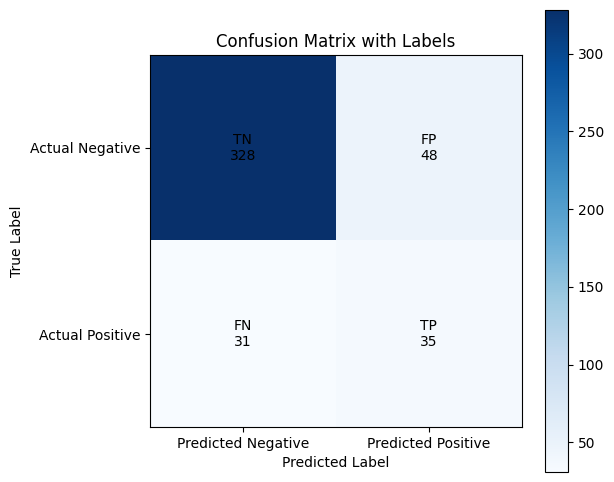

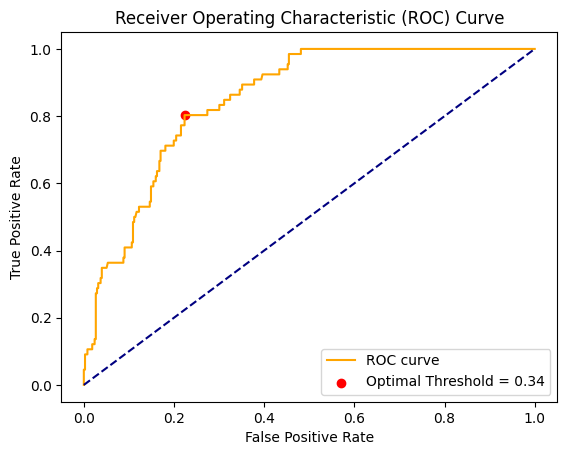

ROC 커브로부터 구한 AUC : 0.8507213088330109
Composite Score :  0.6924613802856111


In [ ]:
test_process(X_test, y_test, model)

# RandomForest / All features / Default / Labelencoding (10)



In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# LabelEncoder 객체 생성
encoder = LabelEncoder()

# 데이터에 fit_transform 메서드 적용
X_train['Education'] = encoder.fit_transform(X_train['Education'])
X_train['Marital_Status'] = encoder.fit_transform(X_train['Marital_Status'])

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        bootstrap=False,
        class_weight={0:1, 1:40},
        n_estimators=400,
        max_features='auto',
        min_samples_leaf=4,
        min_samples_split=10,
        random_state=42))
])

model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['Age', 'Complain',
                                                   'Dt_Customer', 'Income',
                                                   'Kidhome', 'MntFishProducts',
                                                   'MntFruits', 'MntGoldProds',
                                                   'MntMeatProducts',
                                                   'MntSweetProducts',
                                                   'MntWines',
                                                   'NumCatalogPurchases',
                                                   'NumDealsPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebPurchases',
                                                   'NumWebVisitsMonth',
                                                   'Recency', 'Teenhome'])])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight={0: 1, 1: 40},
                                        max_features='auto', min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=400,
                                        random_state=42))])

In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.94      0.87      0.90       297
         Yes       0.50      0.70      0.58        57

    accuracy                           0.84       354
   macro avg       0.72      0.78      0.74       354
weighted avg       0.87      0.84      0.85       354



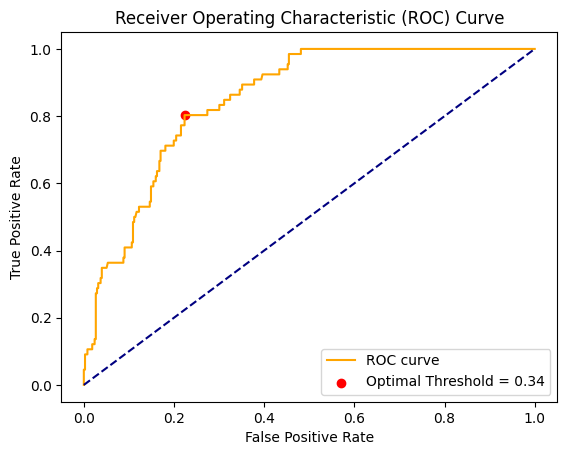

ROC 커브로부터 구한 AUC : 0.8507213088330109
              precision    recall  f1-score   support

          No       0.91      0.87      0.89       376
         Yes       0.42      0.53      0.47        66

    accuracy                           0.82       442
   macro avg       0.67      0.70      0.68       442
weighted avg       0.84      0.82      0.83       442



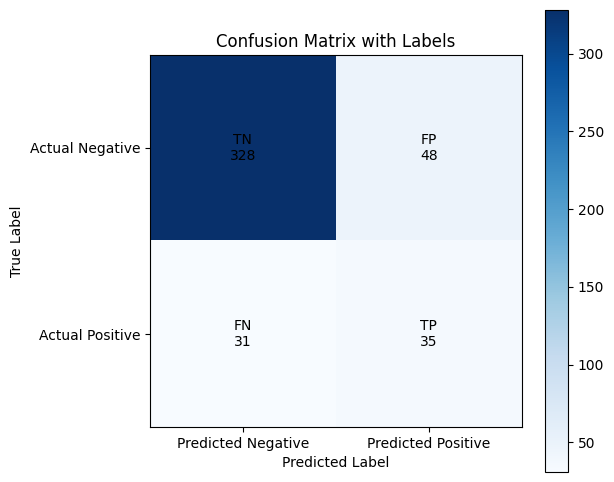

Composite Score :  0.6924613802856111
f1 Score :  0.4697986577181208
Accuracy :  0.8212669683257918
AUC :  0.8507213088330109


In [ ]:
test_process(X_test, y_test, model)

# RandomForest / All features / Default / standardscaler (11)



In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', StandardScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status']),
                                                 ('scaler', StandardScaler(),
                                                  ['Age', 'Complain',
                                                   'Dt_Customer', 'Income',
                                                   'Kidhome', 'MntFishProducts',
                                                   'MntFruits', 'MntGoldProds',
                                                   'MntMeatProducts',
                                                   'MntSweetProducts',
                                                   'MntWines',
                                                   'NumCatalogPurchases',
                                                   'NumDealsPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebPurchases',
                                                   'NumWebVisitsMonth',
                                                   'Recency', 'Teenhome'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.88      0.99      0.93       297
         Yes       0.80      0.28      0.42        57

    accuracy                           0.87       354
   macro avg       0.84      0.63      0.67       354
weighted avg       0.86      0.87      0.85       354



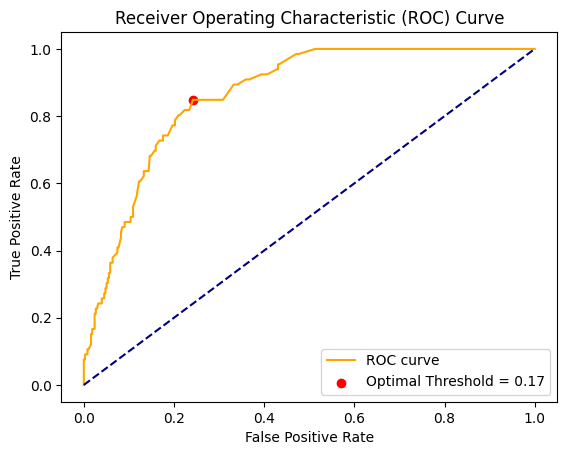

ROC 커브로부터 구한 AUC : 0.8649057059961316
              precision    recall  f1-score   support

          No       0.88      0.97      0.92       376
         Yes       0.58      0.21      0.31        66

    accuracy                           0.86       442
   macro avg       0.73      0.59      0.62       442
weighted avg       0.83      0.86      0.83       442



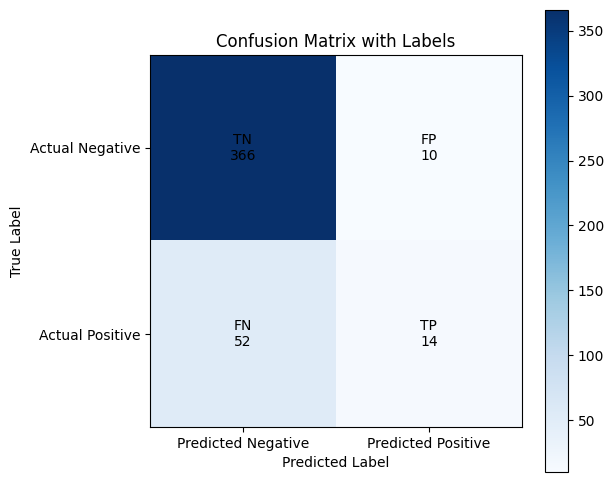

Composite Score :  0.6423524282003632
f1 Score :  0.3111111111111111
Accuracy :  0.8597285067873304
AUC :  0.8649057059961316


In [ ]:
test_process(X_test, y_test, model)

# GradientBoost / All features


In [ ]:
# 데이터 로드
X_train, X_val, y_train, y_val, X_test, y_test = data_seperation(test_size=0.2)

# 범주형 변수와 수치형 변수를 나누기
categorical_cols = ['Education', 'Marital_Status']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

In [ ]:
# 파이프라인 설정
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_cols),
    ('scaler', MinMaxScaler(), numeric_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        learning_rate=0.1,
        max_depth=5,
        n_estimators=150,
        random_state=42
    ))
])

model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['Age', 'Complain',
                                                   'Dt_Customer', 'Income',
                                                   'Kidhome', 'MntFishProducts',
                                                   'MntFruits', 'MntGoldProds',
                                                   'MntMeatProducts',
                                                   'MntSweetProducts',
                                                   'MntWines',
                                                   'NumCatalogPurchases',
                                                   'NumDealsPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebPurchases',
                                                   'NumWebVisitsMonth',
                                                   'Recency', 'Teenhome'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, n_estimators=150,
                                            random_state=42))])

In [ ]:
# validation set test
expected = y_val
predicted = model.predict(X_val)
predicted = predicted.flatten()
predicted = np.where(predicted > 0.5, 1, 0)

# f1 score, acc, ...
classificationReport = classification_report(expected, predicted, target_names=['No', 'Yes'])
print('='*80)
print(classificationReport)
print('='*80)

              precision    recall  f1-score   support

          No       0.91      0.95      0.93       297
         Yes       0.65      0.49      0.56        57

    accuracy                           0.88       354
   macro avg       0.78      0.72      0.74       354
weighted avg       0.87      0.88      0.87       354



              precision    recall  f1-score   support

          No       0.90      0.94      0.92       376
         Yes       0.53      0.41      0.46        66

    accuracy                           0.86       442
   macro avg       0.71      0.67      0.69       442
weighted avg       0.84      0.86      0.85       442



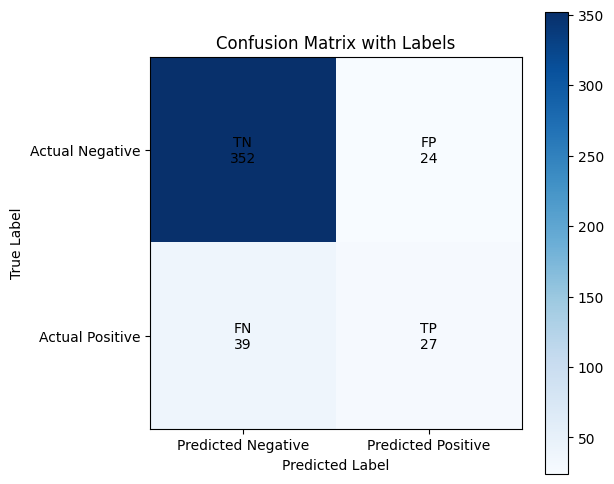

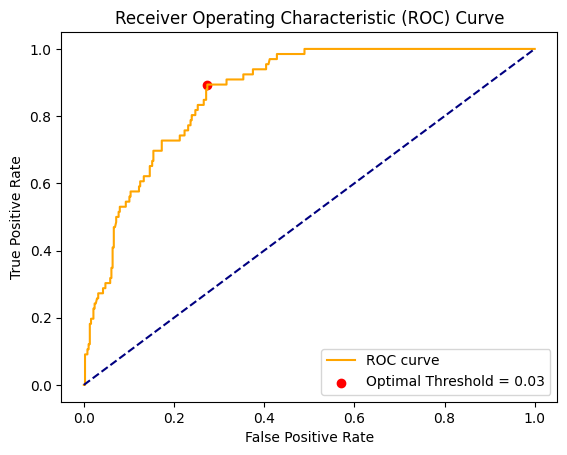

ROC 커브로부터 구한 AUC : 0.869660702772405


In [ ]:
test_process(X_test, y_test, model)

# Score

In [ ]:
for i, score in enumerate(score_list):
    print(f'{i} model score = ', score)
print(max(score_list))
# 8 4 7

0 model score =  0.6478350294207071
1 model score =  0.6151353831221523
2 model score =  0.5917219878577826
3 model score =  0.6316595117439925
4 model score =  0.7065942007512722
5 model score =  0.6961071799150649
6 model score =  0.6820143363103314
7 model score =  0.7042596903860985
8 model score =  0.7119256369412815
9 model score =  0.6953855678717349
10 model score =  0.6026223887211808
11 model score =  0.6924613802856111
12 model score =  0.6423524282003632
0.7119256369412815
